In [2]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
unzip:  cannot find or open /content/drive/MyDrive/dataset, /content/drive/MyDrive/dataset.zip or /content/drive/MyDrive/dataset.ZIP.


In [3]:
import numpy as np

import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torchvision import transforms

import sklearn
from sklearn.neighbors import NearestNeighbors

from PIL import Image

### **Feature Extractor** 

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.to(device)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### **Prepare data**

In [5]:
num_samples = 9605

image_embeddings = torch.tensor([])

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])



for index in range(num_samples):
    image = Image.open(f'/content/drive/MyDrive/dataset/{str(index).zfill(4)}.png')

    if image.mode != 'RGB':
        image = Image.merge('RGB', (image, image, image))

    image = transform(image)
    image = image.unsqueeze(0)
    image = image.to(device)

    with torch.no_grad():
        image_embedding = model.forward(image)

    image_embeddings = torch.cat((image_embeddings, image_embedding))

    if (index + 1) % 1000 == 0:
        print(f'{index + 1} images read')

print('all images read')

1000 images read
2000 images read
3000 images read
4000 images read
5000 images read
6000 images read
7000 images read
8000 images read
9000 images read


### **KNN**

In [6]:
X = image_embeddings.cpu().numpy()

knn = NearestNeighbors(n_neighbors=7, metric='euclidean')

knn.fit(X)

distances, indices = knn.kneighbors(X)

### **Results**

In [7]:
def give_image(image_name):
    image = Image.open(f'/content/drive/MyDrive/dataset/{image_name}.png')
    return torch.tensor(np.array(image))

In [8]:
num_samples = 10

random_sample = [random.randint(0, len(image_embeddings)) for _ in range(num_samples)]
print(random_sample)

[9115, 2914, 7101, 2499, 3336, 7772, 7189, 7664, 8169, 3692]


sample 1


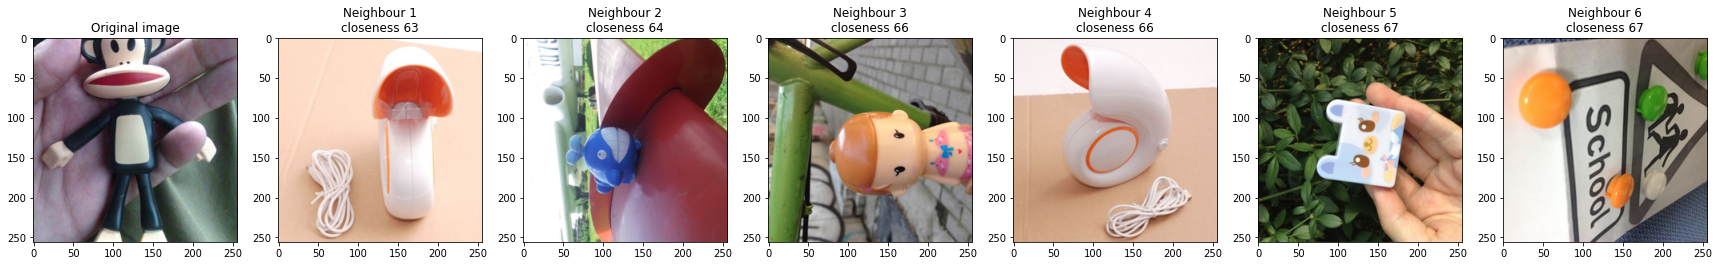

sample 2


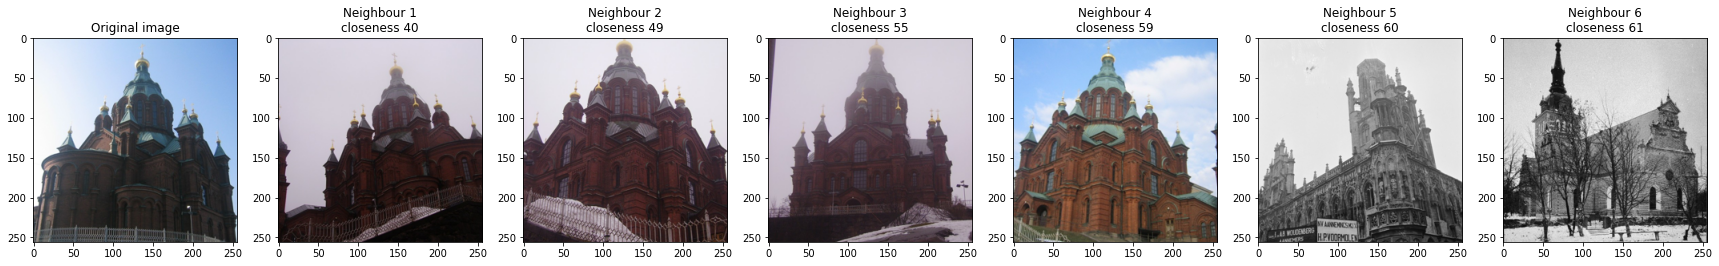

sample 3


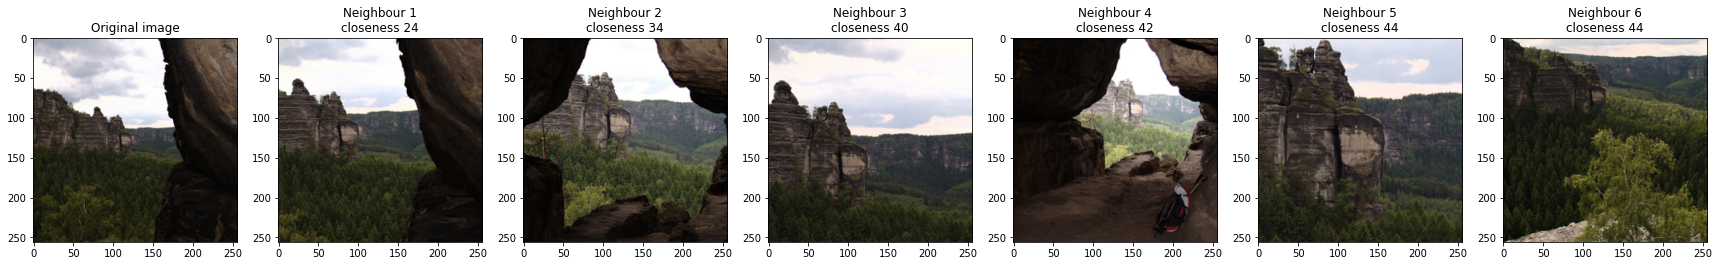

sample 4


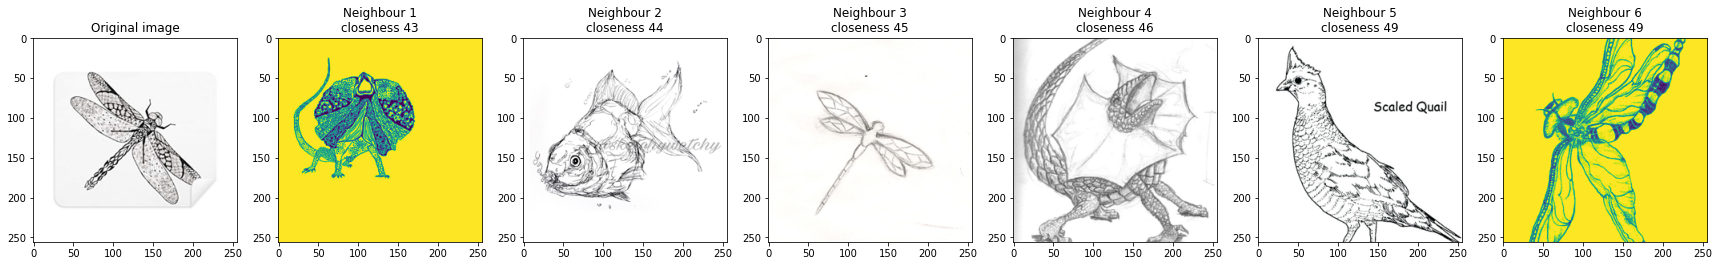

sample 5


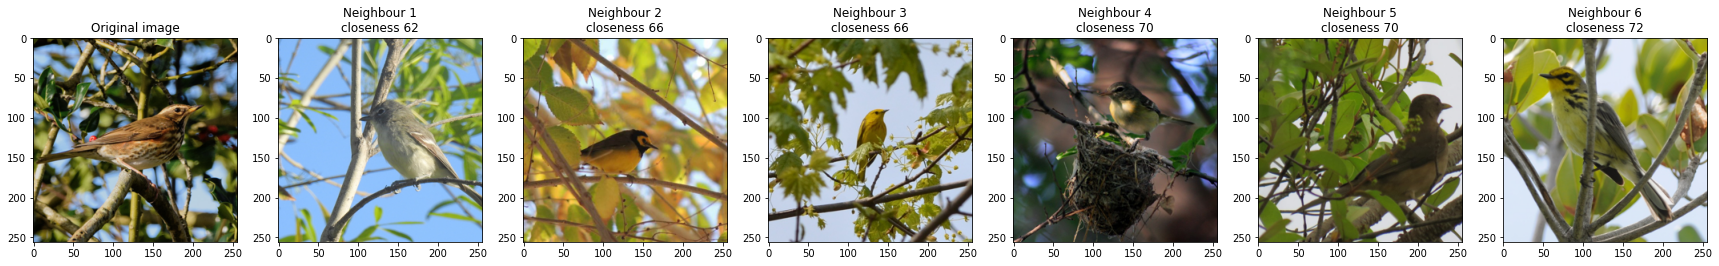

sample 6


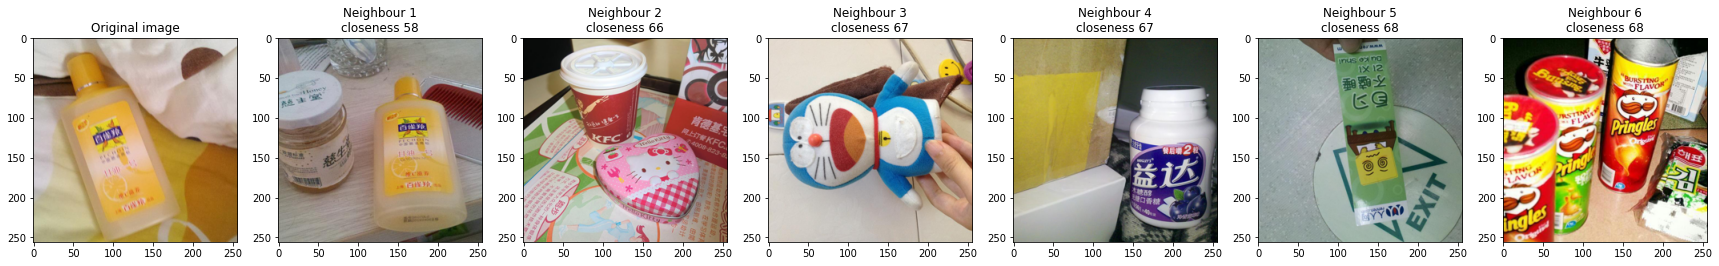

sample 7


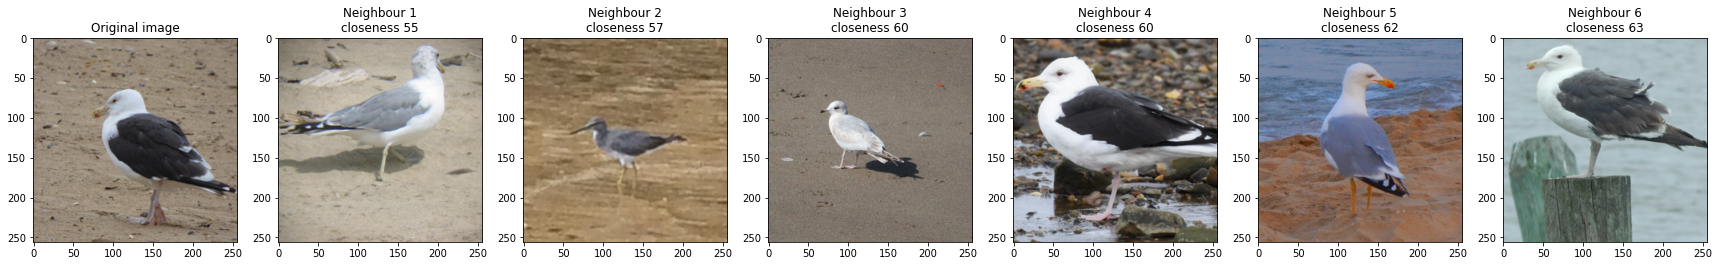

sample 8


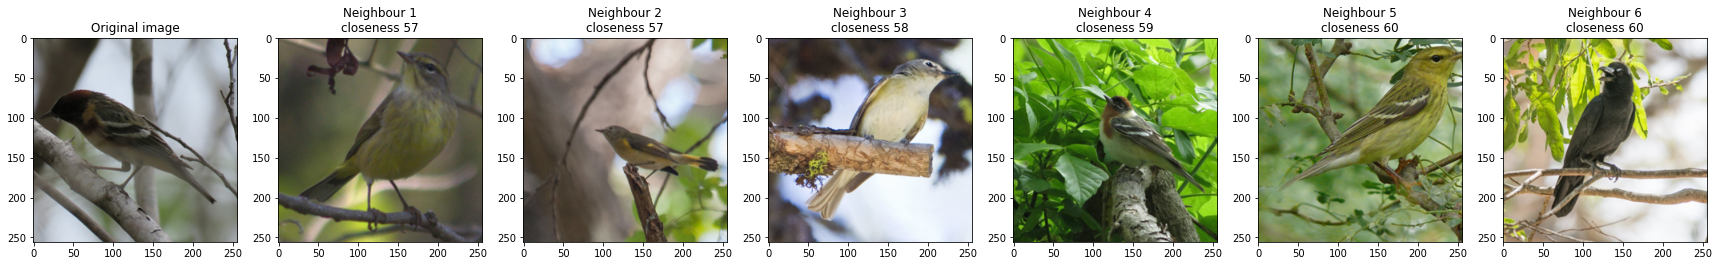

sample 9


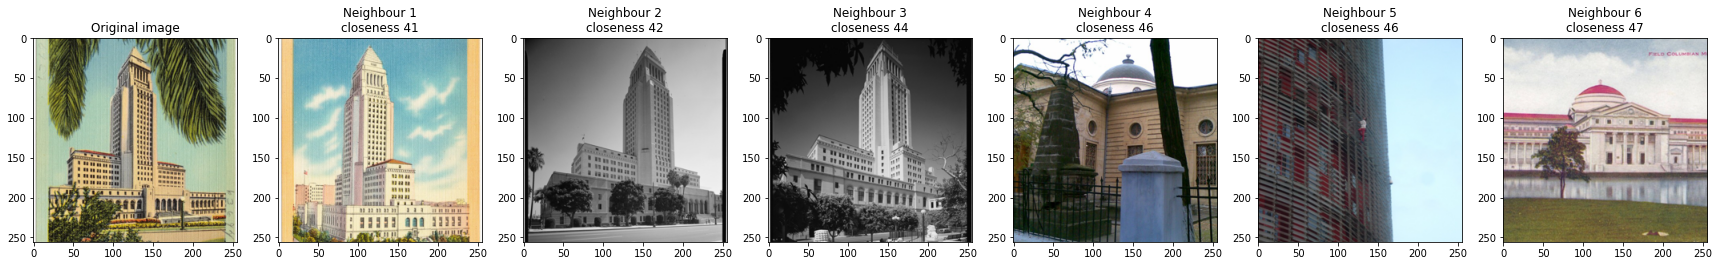

sample 10


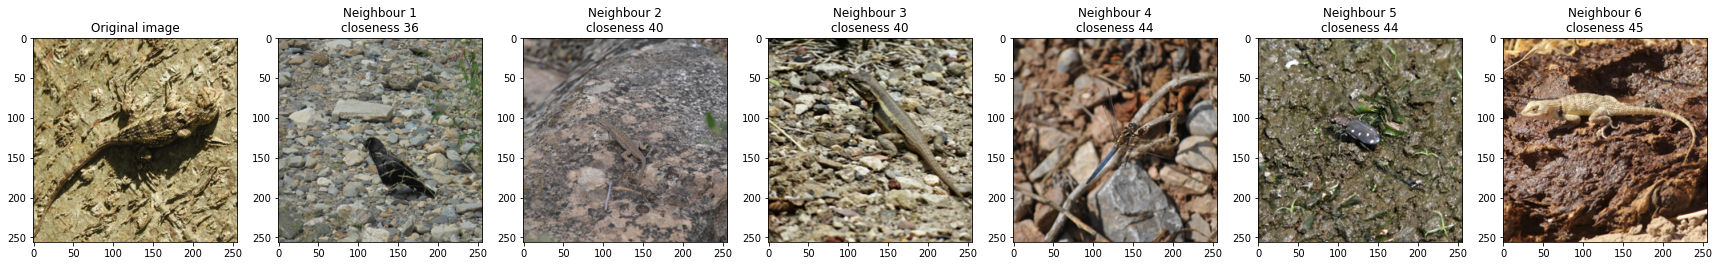

In [9]:
for index, sample_idx in enumerate(random_sample):
    print('sample', index + 1)

    neighbor_indices = indices[sample_idx]
    neighbor_distances = distances[sample_idx]

    fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(30,30))

    for neighbour_idx, close in enumerate(neighbor_indices):
        image_name = str(close).zfill(4)
        image = give_image(image_name)

        axes[neighbour_idx].imshow(image)

        if neighbour_idx == 0:
            axes[neighbour_idx].set_title('Original image')
        else:
            axes[neighbour_idx].set_title(f'Neighbour {neighbour_idx}\ncloseness {int(neighbor_distances[neighbour_idx])}')

    plt.show()